In [1]:
import torch
import torch
import numpy as np    

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [13]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [14]:
!ls /content/gdrive/

MyDrive


In [15]:
from google.colab import files

files.upload()   # upload kaggle.json for downloading the dataset

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"yauhenikavaliou","key":"5deb9439ecec8ef014fc31d185dcd4d4"}'}

In [16]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [17]:
! chmod 600 ~/.kaggle/kaggle.json

In [18]:
!kaggle datasets list  # just check is everything OK

ref                                                       title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    8MB  2021-02-19 07:57:28           1335        216  1.0              
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           2190         65  1.0              
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            239         17  1.0              
aagghh/crypto-telegram-groups                             Crypto telegram groups                       297MB  2021-02-02 09:5

In [19]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp36-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [20]:
!kaggle competitions download -c journey-springfield

 97% 505M/521M [00:05<00:00, 81.0MB/s]
100% 521M/521M [00:05<00:00, 93.4MB/s]


In [21]:
!ls -l /content/journey-springfield.zip

-rw-r--r-- 1 root root 546224286 Feb 19 19:50 /content/journey-springfield.zip


In [22]:
!unzip -q /content/journey-springfield.zip

In [23]:
!ls -1

characters_illustration.png
gdrive
journey-springfield.zip
kaggle.json
sample_data
sample_submission.csv
testset
train


In [24]:
!ls train/simpsons_dataset/

abraham_grampa_simpson	  groundskeeper_willie	ned_flanders
agnes_skinner		  homer_simpson		nelson_muntz
apu_nahasapeemapetilon	  kent_brockman		otto_mann
barney_gumble		  krusty_the_clown	patty_bouvier
bart_simpson		  lenny_leonard		principal_skinner
carl_carlson		  lionel_hutz		professor_john_frink
charles_montgomery_burns  lisa_simpson		rainier_wolfcastle
chief_wiggum		  maggie_simpson	ralph_wiggum
cletus_spuckler		  marge_simpson		selma_bouvier
comic_book_guy		  martin_prince		sideshow_bob
disco_stu		  mayor_quimby		sideshow_mel
edna_krabappel		  milhouse_van_houten	snake_jailbird
fat_tony		  miss_hoover		troy_mcclure
gil			  moe_szyslak		waylon_smithers


In [25]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [26]:
DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 224   # 299 for inception_v3

DEVICE = torch.device("cuda")

In [27]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        # list of files to downliad
        self.files = sorted(files)
        # working mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [28]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [29]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [30]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [31]:
val_dataset = SimpsonsDataset(val_files, mode='val')

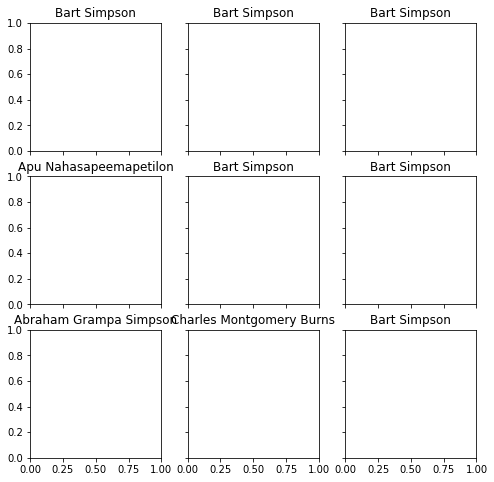

In [32]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [33]:
from torchvision import models

In [44]:
model = models.resnet50(pretrained=True)     # aux_logits=False (for inception)

In [45]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
in_features=2048   # the number of in_features in the last layer of the model

for param in model.parameters():
  param.requires_grad = False   # Freeze layers of the main part of the model

model.fc = nn.Linear(in_features, out_features=42, bias=True)

for param in model.layer4[:8].parameters():
  param.requires_grad = True

In [47]:
lyrs = []
for param in model.parameters():
  lyrs.append(param.requires_grad)  
print(lyrs, ', Number of layers:', len(lyrs))

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, 

In [48]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [49]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [50]:
import torch.nn.functional as F

def focal_loss(outputs, labels, alpha=1, gamma=2):
    BCE_loss = F.binary_cross_entropy(outputs, labels)
    pt = torch.exp(-BCE_loss)
    F_loss = alpha * (1 - pt)**gamma * BCE_loss

    return torch.mean(F_loss)  # F_loss

In [69]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=5e-5)         # optimizer !!!!!!!      
        criterion = nn.CrossEntropyLoss()                           # loss !!!!!!!!!!!!

        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
                        
    return history

In [70]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [71]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = model.to(DEVICE)
print("We will classify: {}".format(n_classes))

We will classify: 42


Start learning

In [72]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [73]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.014892415318304049


epoch:  10%|█         | 1/10 [02:56<26:26, 176.24s/it]


Epoch 001 train_loss: 0.0149     val_loss 0.2310 train_acc 0.9961 val_acc 0.9568
loss 0.005017126024968526


epoch:  20%|██        | 2/10 [05:52<23:30, 176.29s/it]


Epoch 002 train_loss: 0.0050     val_loss 0.2764 train_acc 0.9989 val_acc 0.9582
loss 0.01004010246087791


epoch:  30%|███       | 3/10 [08:48<20:33, 176.19s/it]


Epoch 003 train_loss: 0.0100     val_loss 0.2749 train_acc 0.9978 val_acc 0.9499
loss 0.0162608689888661


epoch:  40%|████      | 4/10 [11:44<17:36, 176.16s/it]


Epoch 004 train_loss: 0.0163     val_loss 0.2260 train_acc 0.9961 val_acc 0.9601
loss 0.0008605395194383189


epoch:  50%|█████     | 5/10 [14:40<14:40, 176.10s/it]


Epoch 005 train_loss: 0.0009     val_loss 0.2344 train_acc 0.9997 val_acc 0.9633
loss 7.698773769966432e-05


epoch:  60%|██████    | 6/10 [17:36<11:44, 176.04s/it]


Epoch 006 train_loss: 0.0001     val_loss 0.2445 train_acc 1.0000 val_acc 0.9645
loss 1.7188561323527893e-05


epoch:  70%|███████   | 7/10 [20:32<08:48, 176.15s/it]


Epoch 007 train_loss: 0.0000     val_loss 0.2538 train_acc 1.0000 val_acc 0.9648
loss 1.115421116488375e-05


epoch:  80%|████████  | 8/10 [23:28<05:52, 176.09s/it]


Epoch 008 train_loss: 0.0000     val_loss 0.2602 train_acc 1.0000 val_acc 0.9654
loss 7.969132673030717e-06


epoch:  90%|█████████ | 9/10 [26:25<02:56, 176.13s/it]


Epoch 009 train_loss: 0.0000     val_loss 0.2661 train_acc 1.0000 val_acc 0.9654
loss 6.028266047603153e-06


epoch: 100%|██████████| 10/10 [29:21<00:00, 176.15s/it]


Epoch 010 train_loss: 0.0000     val_loss 0.2712 train_acc 1.0000 val_acc 0.9658


In [86]:
# save the model
torch.save(model.state_dict(), 'resnet50__simpsons.pth')

Plot learning curves

In [87]:
loss, acc, val_loss, val_acc = zip(*history)

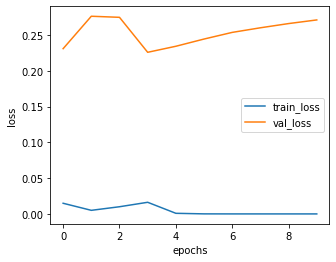

In [88]:
plt.figure(figsize=(5, 4))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

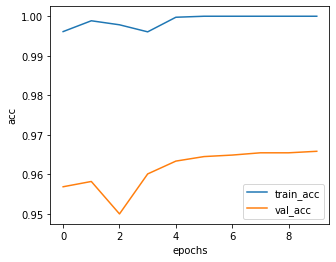

In [89]:
plt.figure(figsize=(5, 4))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [90]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Prediction for one picture"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [91]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [92]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [93]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [94]:
label_encoder

LabelEncoder()

In [95]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Our target metric is f1-score. 

In [97]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

Submit on Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_resnet50.csv', index=False)
# submission file will appear on your google disk

In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset
